In [12]:
"""
Prepare reference data for image chunks, identifying "pure" samples within windows
"""

import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'


In [3]:
# Load the training data (footprints)
gdf_path = os.path.join(maindir, 'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
footprints = gpd.read_file(gdf_path)
footprints.head()

,class_code,areaUTMsqft,uid,description,code,geometry
0,CS,357.783709,1CS,Composition Shingle,0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,CS,918.640862,2CS,Composition Shingle,0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,CS,1383.414170,3CS,Composition Shingle,0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,CS,836.410297,4CS,Composition Shingle,0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,CS,330.514264,5CS,Composition Shingle,0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [6]:
# Calculate the 'optimal' window size from the footprint areas
mean_area_sqft = int(footprints.areaUTMsqft.values.mean())
pct90_area_sqft = np.percentile(footprints.areaUTMsqft, 90)
print(f'Mean footprint area (sqm): {mean_area_sqft * 0.092903}')
print(f'90th percentile footprint area (sqm): {pct90_area_sqft * 0.092903}')

# Convert sqft to sqm
pct90_area_sqm = pct90_area_sqft * 0.092903

# Calculate the side length ('optimal' window size) * 3 
print(f'90th percentile side length (m): {int(np.sqrt(pct90_area_sqm))}')
window_size = (int(np.sqrt(pct90_area_sqm) * 3) - 1)
print(f'Optimal window size: {window_size}')

Mean footprint area (sqm): 99.499113
90th percentile footprint area (sqm): 158.13312473978425
90th percentile side length (m): 12
Optimal window size: 36


In [7]:
# Observe the class imbalance
footprints.class_code.value_counts()

class_code
ME    29651
CS    27687
SL    11080
UR     1018
WS      866
TL      617
SH      589
Name: count, dtype: int64

In [9]:
# Combine SH and WS
ref = footprints.copy()  # Create a copy to avoid modifying the original DataFrame

# Merge the shingle classes (wood shingle and shingle)
merge = {'WS': 'WSH', 'SH': 'WSH'}
ref['class_code'] = ref['class_code'].replace(merge)

print(ref['class_code'].value_counts())  # check the counts

class_code
ME     29651
CS     27687
SL     11080
WSH     1455
UR      1018
TL       617
Name: count, dtype: int64


In [10]:
# Create the centroids for point sampling
reference_pt = ref.copy()
reference_pt['geometry'] = reference_pt['geometry'].centroid

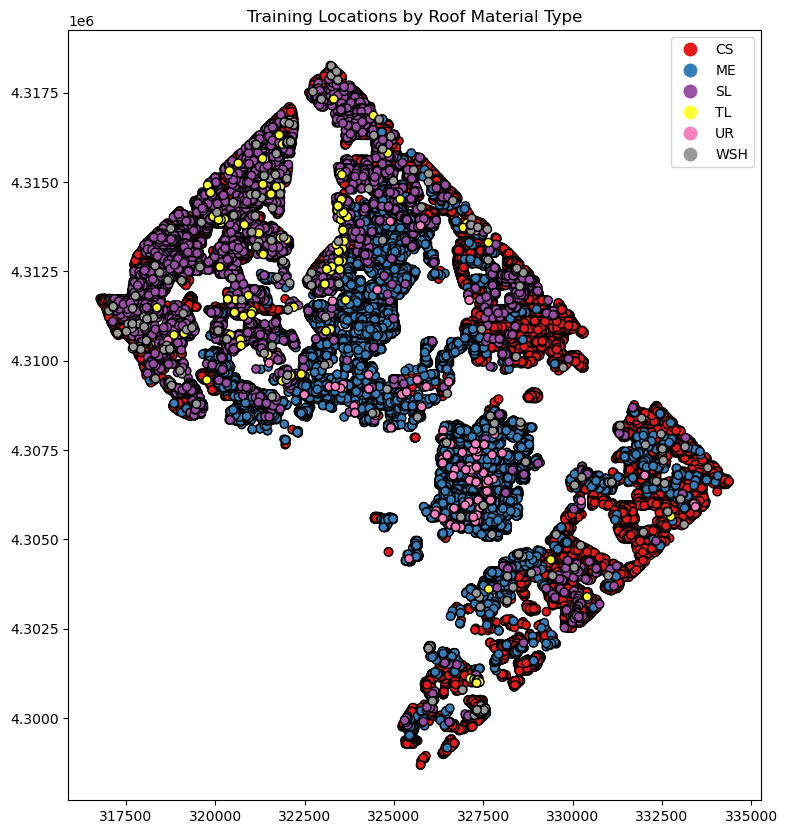

In [13]:
from shapely.geometry import box

window_size = 64
half_window = window_size / 2

# Ensure the GeoDataFrame is in the correct coordinate system
gdf = ref.to_crs(epsg=32618)

# Create training locations with roof types
training_windows = []
training_roof_types = []

# Loop through each footprint individually
for geom, roof_type in zip(gdf.geometry, gdf['class_code']):
    centroid = geom.centroid
    window = box(centroid.x - half_window, centroid.y - half_window,
                 centroid.x + half_window, centroid.y + half_window)

    # Intersect with footprint centroids
    intersect = reference_pt[reference_pt.intersects(window)]
    
    # Get the total count and count for the class
    total_count = len(intersect)
    class_count = len(intersect[intersect['class_code'] == roof_type])

    if total_count > 0 and (class_count / total_count) > 0.50:
        training_windows.append(centroid)
        training_roof_types.append(roof_type)

    del intersect, centroid, window

# Create a GeoDataFrame for the training windows with roof types
training_gdf = gpd.GeoDataFrame({'geometry': training_windows, 'class_code': training_roof_types}, crs=gdf.crs)

# Plot the training locations with colors based on roof type
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='grey', alpha=0.5, edgecolor='none')
training_gdf.plot(column='class_code', ax=ax, legend=True, cmap='Set1', edgecolor='black')
plt.title('Training Locations by Roof Material Type')
plt.show()

In [15]:
print(training_gdf.class_code.value_counts())

class_code
ME     28385
CS     24369
SL      8235
WSH      475
UR       252
TL       198
Name: count, dtype: int64


In [17]:
# Save this file out

training_gdf.to_file(os.path.join(maindir,'data/spatial/mod/dc_data/training/reference_samples_pure.gpkg'))